In [1]:
# in case there are any problems with importing because path is wrong
import sys
sys.path.append('/Users/daniel/Princeton Dropbox/Daniel Gurevich/Research/discrete_sr/code/SPIDER_discrete')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from matplotlib import rcParams
import h5py
import matplotlib.pyplot as plt

from library import Observable
from continuous.process_library_terms import SRDataset
from utils import save, load

In [3]:
hdf = False
if hdf:
    import h5py
    
    def load_matlab_v73(mat_file_path):
        """
        Loads MATLAB v7.3 .mat data using h5py and converts it to Python-readable formats.
    
        Parameters:
        - mat_file_path (str): Path to the .mat file.
    
        Returns:
        - dict: A dictionary with MATLAB variable names as keys and corresponding NumPy arrays as values.
        """
        try:
            # Open the HDF5 file
            with h5py.File(mat_file_path, 'r') as f:
                mat_data = {}
    
                def recursively_load(group):
                    """
                    Recursively load MATLAB v7.3 groups into dictionaries.
                    """
                    data = {}
                    for key, item in group.items():
                        if isinstance(item, h5py.Dataset):
                            data[key] = np.array(item)  # Convert HDF5 dataset to NumPy array
                        elif isinstance(item, h5py.Group):
                            data[key] = recursively_load(item)  # Recursively process groups
                    return data
    
                # Load all variables from the root group
                mat_data = recursively_load(f)
    
            return mat_data
        except Exception as e:
            print(f"Error loading .mat file: {e}")
            return None
    
    # Path to your MATLAB v7.3 .mat file
    mat_file_path = "Matteo.mat" # Replace with your .mat file path

In [4]:
if hdf:
    # Load the .mat file
    python_data = load_matlab_v73(mat_file_path)
    
    # Display the loaded data
    if python_data:
        for var_name, data in python_data.items():
            if isinstance(data, np.ndarray):
                print(f"Variable: {var_name}, Shape: {data.shape}, Type: {type(data)}")
            else:
                print(f"Variable: {var_name}, Type: {type(data)} (nested structure)")
    
    s = python_data['s']  # Replace 's' with the actual key name if it's different
    
    # Extract the first layer (V) and the second layer (U)
    V = s[:, 0, :, :]  # First layer
    U = s[:, 1, :, :]  # Second layer
    Lx = 2*np.pi; Ly = 2*np.pi; Lt = 0.01;
    Nx = 2048; Ny = 2048; Nt = 100 # analytical
    dx = Lx/Nx; dy = Ly/Ny; dt = Lt/Nt;
    
    # Display their shapes
    
    U = np.transpose(U, (2,1,0))
    V = np.transpose(V, (2,1,0))
    
    def pressure_poisson(U, V, dx, dy, density=1.0):
        nx, ny, nt = U.shape
        kx = np.fft.fftfreq(nx, d=dx) * 2 * np.pi
        ky = np.fft.rfftfreq(ny, d=dy) * 2 * np.pi
        kx, ky = np.meshgrid(kx, ky, indexing='ij')
        k_squared = kx**2 + ky**2
        k_squared[0, 0] = np.inf 
        P = np.zeros((nx, ny, nt))
        for t in range(nt):
            u_FT = np.fft.rfftn(U[:, :, t])
            v_FT = np.fft.rfftn(V[:, :, t])
            i = 1j
            dxu = np.fft.irfftn(i * kx * u_FT, s=(nx, ny))
            dyu = np.fft.irfftn(i * ky * u_FT, s=(nx, ny))
            dxv = np.fft.irfftn(i * kx * v_FT, s=(nx, ny))
            dyv = np.fft.irfftn(i * ky * v_FT, s=(nx, ny))
            rhs = dxu**2 + 2 * dyu * dxv + dyv**2
            rhs_FT = np.fft.rfftn(rhs)
            pressure_FT = density * rhs_FT / k_squared
            pressure = np.fft.irfftn(pressure_FT, s=(nx, ny))
            P[:, :, t] = pressure
        return P
    
    P = pressure_poisson(U, V, dx, dy)
    
    #SAMPLE
    xsample = 2
    ysample = xsample
    tsample = 1
    
    U = U[::xsample, ::ysample, ::tsample]
    V = V[::xsample, ::ysample, ::tsample]
    P = P[::xsample, ::ysample, ::tsample]
    
    Nx = 2048/xsample; Ny = 2048/ysample; Nt = 100/tsample
    dx = Lx/Nx; dy = Ly/Ny; dt = Lt/Nt;
    
    print(f"V: Shape = {V.shape}, Type = {type(V)}")
    print(f"U: Shape = {U.shape}, Type = {type(U)}")
    print(f"P: Shape = {P.shape}, Type = {type(P)}")

    u = np.concatenate([U[:, :, :, np.newaxis], V[:, :, :, np.newaxis]], axis=3)

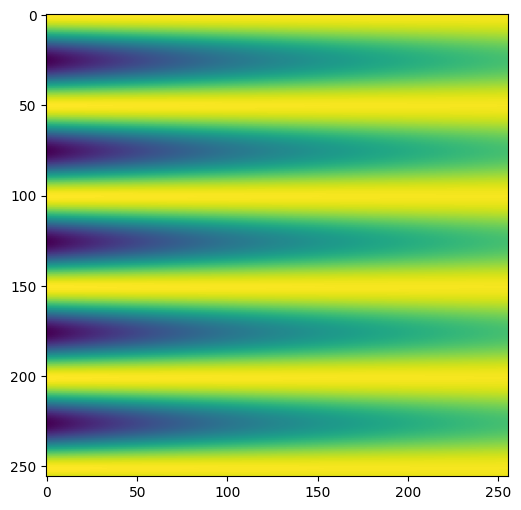

In [5]:
tgv = True
if tgv:    
    Lx = 4; Ly = 4; Lt = 1;
    Nx = 256; Ny = Nx; Nt = Nx # analytical
    dx = Lx/Nx; dy = Ly/Ny; dt = Lt/Nt;
    
    # don't use MATLAB data
    x = np.arange(0, 4, dx); y = np.arange(0, 4, dy); t = np.arange(0, 1, dt)
    xg, yg = np.meshgrid(x, y)
    # U = 4*np.einsum('i,j,k->ijk', np.sin(4*x), np.cos(4*y), np.exp(-0.32*t))
    # V = -4*np.einsum('i,j,k->ijk', np.cos(4*x), np.sin(4*y), np.exp(-0.32*t))
    # P = 4*np.einsum('ij, k->ijk', np.cos(8*xg)+np.cos(8*yg), np.exp(-0.64*t))
    U = 4*np.einsum('i,j,k->ijk', np.sin(4*x), np.cos(4*y), np.exp(-0.64*t))
    V = -4*np.einsum('i,j,k->ijk', np.cos(4*x), np.sin(4*y), np.exp(-0.64*t))
    P = 4*np.einsum('ij, k->ijk', np.cos(8*xg)+np.cos(8*yg), np.exp(-1.28*t))
    u = np.concatenate([U[:, :, :, np.newaxis], V[:, :, :, np.newaxis]], axis=3)
    
    fig, ax= plt.subplots(figsize=(6,6))
    ax.imshow(P[:, 128, :])

In [6]:
HP_test = False
if HP_test:
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Parameters
    Lx = 1
    Ly = 1
    Tfinal = 1.0
    Nx = 1024
    Ny = Nx
    Nt = 50
    
    dpdx = -1.0
    mu   = 0.1
    P0   = 0
    U_max = -(dpdx) * Ly**2 / (8 * mu)  # Maximum velocity for Poiseuille flow
    
    # Grid
    x = np.linspace(-Lx/2, Lx/2, Nx)
    y = np.linspace(-Ly/2, Ly/2, Ny)
    X, Y = np.meshgrid(x, y, indexing='ij')
    
    t  = np.linspace(0, Tfinal, Nt)
    dt = t[1]-t[0]
    
    # Poiseuille flow in original orientation (along X-axis)
    #   U(x,y) = U_max * [1 - (y/(Ly/2))^2]
    #   V(x,y) = 0
    #   P(x,y) = P0 + dpdx * X
    V_2D = np.zeros_like(X)
    #P_2D = (P0 + dpdx * X)
    
    theta_deg = 45
    theta = np.radians(theta_deg)
    cos_t = np.cos(theta)
    sin_t = np.sin(theta)
    X_rot = X * cos_t - Y * -sin_t  
    Y_rot = X * -sin_t + Y * cos_t
    
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    
    U_2D = U_max * (1.0 - (Y_rot / (Ly/2))**2)
    P_2D = P0 + dpdx * (X_rot)
            
    U_rot_2D = U_2D * cos_t - V_2D * sin_t
    V_rot_2D = U_2D * sin_t + V_2D * cos_t
    
    # Replicate fields over time
    U_rot = np.repeat(U_rot_2D[:, :, None], Nt, axis=2)
    V_rot = np.repeat(V_rot_2D[:, :, None], Nt, axis=2)
    P_rot = np.repeat(P_2D[:, :, None], Nt, axis=2)
    
    u = np.concatenate([U_rot[:, :, :, np.newaxis], V_rot[:, :, :, np.newaxis]], axis=3)
    P = P_rot
    #print(u[72:74, 767:769, 9, 0])
    
    # Plot a snapshot at t=0
    time_index = 0
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    
    im0 = axs[0].imshow(U_rot[:, :, time_index].T, extent=[x[0], x[-1], y[0], y[-1]],
                        origin='lower', aspect='auto', cmap='viridis')
    axs[0].set_title("U (rotated) at t=0")
    plt.colorbar(im0, ax=axs[0])
    
    im1 = axs[1].imshow(V_rot[:, :, time_index].T, extent=[x[0], x[-1], y[0], y[-1]],
                        origin='lower', aspect='auto', cmap='viridis')
    axs[1].set_title("V (rotated) at t=0")
    plt.colorbar(im1, ax=axs[1])
    
    im2 = axs[2].imshow(P_rot[:, :, time_index].T, extent=[x[0], x[-1], y[0], y[-1]],
                        origin='lower', aspect='auto', cmap='viridis')
    axs[2].set_title("P (original) at t=0")
    plt.colorbar(im2, ax=axs[2])
    
    for ax in axs:
        ax.set_xlabel("x")
        ax.set_ylabel("y")
    
    plt.tight_layout()

In [7]:
#%%prun # profiling

uobs = Observable(string='u', rank=1)
pobs = Observable(string='p', rank=0)
observables = [uobs, pobs]
data_dict = {'p': P, 'u': u}

# fix random seed
np.random.seed(1)

world_size = np.array(P.shape)
pad = 0

# fix random seed
np.random.seed(1)

dxs = [dx, dy, dt]

# initial setup of dataset
srd = SRDataset(world_size=world_size, data_dict=data_dict, observables=observables, dxs=dxs, 
                irreps=SRDataset.all_rank2_irreps())
                #irreps=(0, 1, 2))

# initialize libraries, domains, and weights
srd.make_libraries(max_complexity=4, max_observables=3)
#srd.make_libraries(max_complexity=5, max_observables=3)
for irrep in srd.irreps:
    print(irrep, ":", len(srd.libs[irrep].terms))

dom_width = 40
dom_time = 20 #previously 20 (without interpolation)
srd.make_domains(ndomains=30, domain_size=[dom_width, dom_width, dom_time], pad=pad)
#srd.make_domains(ndomains=10, domain_size=[dom_width, dom_width, dom_time], pad=pad)
srd.make_weights(m=12, qmax=0)
srd.set_LT_scale(L=3/8, T=2.5e-3) #T=1 # note that this line must go before make_library_matrices
srd.make_library_matrices(debug=False)

Rank 0 : 42
Rank 1 : 49
Antisymmetric rank 2 : 23
Symmetric trace-free rank 2 : 36


In [8]:
from commons.utils import *

lib1 = srd.libs[srd.irreps[1]]
for match in regex_find(lib1.terms, r'∂t u_α'):
    print(match)
dtu = lib1.Q[:, match[0]]

for match in regex_find(lib1.terms, r'u_β · ∂β u_α'):
    print(match)
adv = lib1.Q[:, match[0]]

for match in regex_find(lib1.terms, r'∂α p'):
    print(match)
dp = lib1.Q[:, match[0]]

for match in regex_find(lib1.terms, r'∂β² u_α'):
    print(match)
viscosity = 0.02*lib1.Q[:, match[0]] #0.1

print(np.linalg.norm(dtu), np.linalg.norm(adv), np.linalg.norm(dp), np.linalg.norm(dtu+dp+adv-viscosity), 
      np.linalg.norm(dp-viscosity), np.linalg.norm(dtu+adv))

(11, ∂t u_α)
(34, u_β · ∂β u_α)
(0, ∂α p)
(10, ∂β² u_α)
2835.3753505391437 39578.945953572955 39578.945962339974 1.0333688687456852e-05 39472.733748303726 39472.73373951621


In [9]:
lib0 = srd.libs[srd.irreps[0]]
for match in regex_find(lib0.terms, r'∂α u_α'):
    print(match)
div = lib0.Q[:, match[0]]

print(np.linalg.norm(div))

(14, ∂α u_α)
6.760307306325996e-12


In [10]:
from commons.identify_models import *
import copy

libs = srd.libs

reg_opts_list = []
for irrep in srd.irreps:
    # for regression we now need to construct a Scaler, Initializer, ModelIterator, and Threshold
    scaler = Scaler(sub_inds=None, char_sizes=libs[irrep].col_weights, row_norms=None)
    init = Initializer(method='combinatorial', start_k=2)
    #init = Initializer(method='combinatorial', start_k=9999)
    #init = Initializer(method='power', start_k=10)
    #res = Residual(residual_type='fixed_column', anchor_col=0)
    res = Residual(residual_type='matrix_relative')
    
    iterator = ModelIterator(max_k=10, backward_forward=True, brute_force=True, max_passes=10)
    thres = Threshold(threshold_type='jump', gamma=1.5, delta=1e-8, n_terms=None)
    #thres = Threshold(threshold_type='information', ic=AIC)
    #thres = Threshold(threshold_type='jump', gamma=1.5, n_terms=3)
    
    opts = {'scaler': scaler, 'initializer': init, 'residual': res,
            'model_iterator': iterator, 'threshold': thres}
    opts['verbose'] = False
    opts['inhomog'] = False
    opts['inhomog_col'] = None
    reg_opts_list.append(opts)

eqs, lambdas, reg_results, derived_eqs, excluded_terms = interleave_identify([libs[i] for i in srd.irreps], 
reg_opts_list, threshold=1e-6, experimental=True)
#, max_equations=10)

--- WORKING ON LIBRARY WITH IRREP Rank 0 AT COMPLEXITY 1 ---
--- WORKING ON LIBRARY WITH IRREP Rank 1 AT COMPLEXITY 1 ---
--- WORKING ON LIBRARY WITH IRREP Antisymmetric rank 2 AT COMPLEXITY 1 ---
--- WORKING ON LIBRARY WITH IRREP Symmetric trace-free rank 2 AT COMPLEXITY 1 ---
--- WORKING ON LIBRARY WITH IRREP Rank 0 AT COMPLEXITY 2 ---
[0.00 s]
Identified model: ∂α u_α = 0 (order 2, residual 2.98e-17)
[0.24 s]
Identified model: p + 0.781 · ∂t p = 0 (order 2, residual 1.13e-18)
--- WORKING ON LIBRARY WITH IRREP Rank 1 AT COMPLEXITY 2 ---
[0.00 s]
Identified model: 0.64 · u_α + ∂t u_α = 0 (order 2, residual 9.64e-19)
--- WORKING ON LIBRARY WITH IRREP Antisymmetric rank 2 AT COMPLEXITY 2 ---
--- WORKING ON LIBRARY WITH IRREP Symmetric trace-free rank 2 AT COMPLEXITY 2 ---
--- WORKING ON LIBRARY WITH IRREP Rank 0 AT COMPLEXITY 3 ---
[0.00 s]
Identified model: p + 0.0156 · ∂α² p = 0 (order 3, residual 4.06e-15)
--- WORKING ON LIBRARY WITH IRREP Rank 1 AT COMPLEXITY 3 ---
[0.01 s]
Identifi

In [11]:
print(derived_eqs)
print([reg_result.all_lambdas for reg_result in reg_results])

{'∂α u_α = 0': [∂α u_α, ∂t ∂α u_α, ∂t² ∂α u_α, ∂t ∂α ∂β u_β, p · ∂t ∂α u_α, u_α · ∂t ∂β u_β, ∂α ∂β u_β, ∂t ∂α ∂β u_β, ∂α ∂β ∂γ u_γ, ∂α² ∂β u_β, p · ∂α ∂β u_β, u_α · ∂β ∂γ u_γ, u_α · ∂α ∂β u_β, p · ∂α u_α, p · ∂t ∂α u_α + ∂t p · ∂α u_α, p · ∂α ∂β u_β + ∂α p · ∂β u_β, p · p · ∂α u_α, p · u_α · ∂β u_β, ∂β u_β · ∂t u_α, ∂α u_β · ∂γ u_γ, ∂α u_α · ∂β u_β, ∂t p · ∂α u_α, ∂α p · ∂β u_β, u_α · ∂β u_β, u_α · ∂t ∂β u_β + ∂β u_β · ∂t u_α, u_α · ∂β ∂γ u_γ + ∂β u_α · ∂γ u_γ, u_α · ∂α ∂β u_β + ∂α u_α · ∂β u_β, p · u_α · ∂β u_β, u_α · u_β · ∂γ u_γ, u_α · u_α · ∂β u_β], 'p + 0.7812499997567885 · ∂t p = 0': [1.2800000003984777 · p + ∂t p, 1.2800000003984777 · ∂t p + ∂t² p, 1.2800000003984777 · ∂t² p + ∂t³ p, 1.2800000003984777 · ∂t ∂α p + ∂t² ∂α p, 1.2800000003984777 · p · ∂t p + p · ∂t² p, 1.2800000003984777 · ∂t p · u_α + ∂t² p · u_α, 1.2800000003984777 · ∂α p + ∂t ∂α p, 1.2800000003984777 · ∂t ∂α p + ∂t² ∂α p, 1.2800000003984777 · ∂α ∂β p + ∂t ∂α ∂β p, 1.2800000003984777 · ∂α² p + ∂t ∂α² p, 1.2800000